# Pokemon GAN Training Notebook

**Import libraries**

In [9]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from dataset import PokemonDataset
from ACGAN import AuxGAN
from utils import show_tensor_images
import variable as var
import os

**Load labels**

In [2]:
resume_training = False
train_number = 1
gan_id = f"acgan_pokemon_train_{train_number}"

greyscale = False
resize_image_dim = 64
n_conv_block = 3
batch_size = 128

In [3]:
dset = PokemonDataset(greyscale, resize=[resize_image_dim, resize_image_dim], 
                      shiny=True, frame2=True)
dloader = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=0)

dloader = DataLoader(
    MNIST(os.environ['DATASETS'], 
          download=False, 
          transform=transforms.Compose([transforms.ToTensor(), 
                                        transforms.Resize([resize_image_dim, resize_image_dim])
                                       ])
         ), 
    batch_size=batch_size,
    shuffle=True)

In [4]:
len(dloader)*batch_size

1280

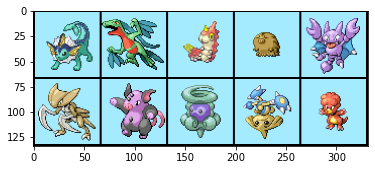

tensor([ 2,  0,  3, 13,  7, 11, 10,  4,  9,  1,  3,  3,  7,  4,  6,  0,  3,  2,
        10,  3,  9,  2,  4,  2,  0,  2,  7,  0,  0,  6, 11,  1,  3,  7,  9, 10,
        10,  4,  2, 10,  6, 10,  2, 16, 11, 13, 10, 16,  1,  2,  0,  5,  0,  0,
         4, 11, 12,  4,  6, 12,  3,  4,  2,  0,  7,  1,  3,  4,  5, 11,  0,  2,
        14,  4, 15,  4, 11,  1,  3, 16, 15, 11,  2,  1,  3,  0, 11,  8,  1,  4,
         6,  2,  3,  3,  7, 10,  2,  1,  2,  2, 10,  0,  3,  3,  2,  2,  2,  1,
        10,  3,  1, 13,  5, 11,  9, 11,  2,  2, 10,  2,  2,  2, 10, 13, 16, 16,
        16,  6])

In [5]:
images, labels = next(iter(dloader))
show_tensor_images(images)
labels

**GAN Component**

In [6]:
betas = (.5, .999)
n_channel = 1 if greyscale else 3
n_feature = 64
z_dim = 100
n_classes = len(dset.label_map)
    
params = {'gen': {'n_feature': n_feature,
                  'n_channel': n_channel,
                  'lr': 1e-4,
                  'betas': betas},
          'disc': {'n_channel': n_channel,
                   'n_feature': n_feature,
                   'lr': 1e-4,
                   'betas': betas},
          'z_dim': z_dim,
          'n_conv_block': n_conv_block,
          'n_classes': n_classes
         }

In [7]:
gan = AuxGAN(params)
if os.path.exists(f'data/models/{gan_id}.pth'):
    print('RESUMING TRAINING...')
    gan.load_model(f'data/models/{gan_id}.pth')
else:
    print('NEW TRAINING...')

RESUMING TRAINING...


In [8]:
gan.init_tensorboard(main_dir='runs', subdir=gan_id, port=8008)

In [54]:
gan.train(n_epoch=1000, dataloader=dloader, gan_id=gan_id)

100%|██████████| 1000/1000 [24:45<00:00,  1.49s/it]


**RESULT**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class: steel


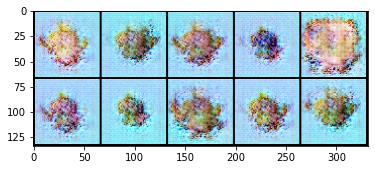

In [83]:
being_class = 1
print(f"class: {dset.label_map[being_class]}")
fakes, classes = gan.generate_fake(10, train=False, being_class=being_class)


show_tensor_images(fakes)

In [114]:
for i_batch, (real, real_classes) in enumerate(dloader):
    real = real.to(var.device)
    real_classes = real_classes.to(var.device)
    with torch.no_grad():
        _, real_aux = gan.discriminator(real)
    labels = torch.argmax(real_aux, dim=1)
    print((labels == real_classes).sum()/len(real_classes))

tensor(0.9844, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9609, device='cuda:0')
tensor(0.9844, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9844, device='cuda:0')
tensor(0.9766, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9412, device='cuda:0')


In [103]:
_, real_aux = gan.discriminator(images.to(var.device))

In [112]:
labels

tensor([10, 10,  4,  7,  0, 11, 10,  6, 10, 13,  6,  3, 14, 13,  6,  4,  6,  2,
         6, 13,  4, 14,  2,  3, 10,  2, 11,  0,  2,  0,  0, 16,  4, 10,  2,  4,
         1,  9,  7,  1,  0,  4,  4,  5,  2, 13,  2,  1,  2, 10, 16,  2,  4, 15,
         3,  2,  4,  0, 14,  4, 10,  7,  1,  3,  3,  7, 11,  5,  3, 16,  3,  3,
        14,  3,  4,  2,  3,  1,  7,  6,  0,  2,  5,  3,  6,  3,  2,  4,  0,  5,
         0,  5,  3,  2, 10, 13, 11,  9, 16, 14,  2,  5,  0,  1,  4,  3, 16, 10,
        10,  5,  1,  6,  3, 14, 14,  0, 10,  6, 10, 15,  0, 10,  2,  4, 14,  2,
         7,  4])

In [15]:
(torch.ones((4, )).long() * 5).dtype

torch.int64